In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from matplotlib import pyplot as plt
import datetime
from scipy import stats
from sklearn import feature_selection as fs
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
def prob(data, acu):
    aux=np.zeros(data.shape[0])
    
    #marcando no data frame valores que estao no vetor de acumulados
    data_aux=data.isin({'price':acu})
    
    
    #pegando os indices dos valores que estao no vetor acumulados
    indices=data[data_aux.price].index

    for i in indices:
        aux[i]=1
    return aux

In [4]:
def acumulativo(serie, porcentagem):
    #essa função recebe uma serie e porcentagem, e retornará um vetor tal que a soma de suas
    #frequencias sejam <=porcentagem, alem da soma das probabilidades desses valores e o maior a aparecer
    #obs: valores em vec não se repetem
    vec=[]
    cont=serie.value_counts(normalize=True)
    values=pd.DataFrame(cont.index)
    #ordenando os valores, pois se nao pegar na ordem de menor para maior valor de price, acabará pulando valores
    #na contagem do acumulado
    order=pd.DataFrame(values.sort_values(by=0, ascending=True).reset_index(drop=True))
    acu=0
    for i in order.values:
        value=i[0]
        acu+=cont.loc[value]
        if(acu>porcentagem):
            break
        else:
            vec.append(value)
    return np.resize(vec,(serie.shape[0])), acu, max(vec)[0]

# Tratamento dos Dados

In [5]:
df = pd.read_csv('arquivos/kc_house_data.csv')
df.head(5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3.0,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3.0,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2.0,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4.0,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3.0,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
df.columns, len(df.columns)

(Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
        'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
        'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
        'lat', 'long', 'sqft_living15', 'sqft_lot15'],
       dtype='object'),
 21)

In [7]:
df['date'] = [f'{i[6:8]}'+'/'+f'{i[4:6]}'+'/'+f'{i[0:4]}' for i in df['date']]
df['date'] = [datetime.datetime.strptime(i,'%d/%m/%Y') for i in df['date']]
df.sort_values('date',inplace=True)
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
16768,5561000190,2014-05-02,437500.0,3.0,2.25,1970,35100,2.0,0,0,...,9,1970,0,1977,0,98027,47.4635,-121.991,2340,35100
9596,472000620,2014-05-02,790000.0,3.0,2.50,2600,4750,1.0,0,0,...,9,1700,900,1951,0,98117,47.6833,-122.400,2380,4750
9587,1024069009,2014-05-02,675000.0,5.0,2.50,2820,67518,2.0,0,0,...,8,2820,0,1979,0,98029,47.5794,-122.025,2820,48351
20602,7853361370,2014-05-02,555000.0,4.0,2.50,3310,6500,2.0,0,0,...,8,3310,0,2012,0,98065,47.5150,-121.870,2380,5000
11577,5056500260,2014-05-02,440000.0,4.0,2.25,2160,8119,1.0,0,0,...,8,1080,1080,1966,0,98006,47.5443,-122.177,1850,9000


In [8]:
#colunas excluidas manualmente é importante que tenham acompanhamento de um especialista no tema dos dados
print(df.isnull().sum())
#como existe poucos valores faltantes, irei retira-los
df.dropna(how='any', inplace=True)
df.reset_index(drop=True, inplace=True)

id               0
date             0
price            0
bedrooms         4
bathrooms        0
sqft_living      0
sqft_lot         0
floors           1
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [9]:
colunas=['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'grade']
for i in colunas:
    print(f'{i}=',df[i].unique())

bedrooms= [ 3.  5.  4.  2.  7.  6.  9.  1.  8.  0. 33. 10. 11.]
bathrooms= [2.25 2.5  1.5  1.75 3.25 1.   2.   2.75 3.   3.5  8.   4.25 3.75 4.
 5.   4.5  5.75 1.25 6.5  4.75 0.75 5.25 5.5  6.25 0.   6.75 7.5  0.5
 6.   7.75]
floors= [2.  1.  1.5 2.5 3.  3.5]
waterfront= [0 1]
view= [0 1 2 4 3]
grade= [ 9  8  7  6 10 12 11  5  4 13  1  3]


In [10]:
df['bathrooms']=df['bathrooms'].astype('int')
df['floors']=df['floors'].astype('int')
colunas=['bathrooms', 'floors']
for i in colunas:
    print(f'{i} =',df[i].unique())

bathrooms = [2 1 3 8 4 5 6 0 7]
floors = [2 1 3]


In [11]:
data_series=df[['date','price']]
data_series.set_index('date', inplace = True)

In [12]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

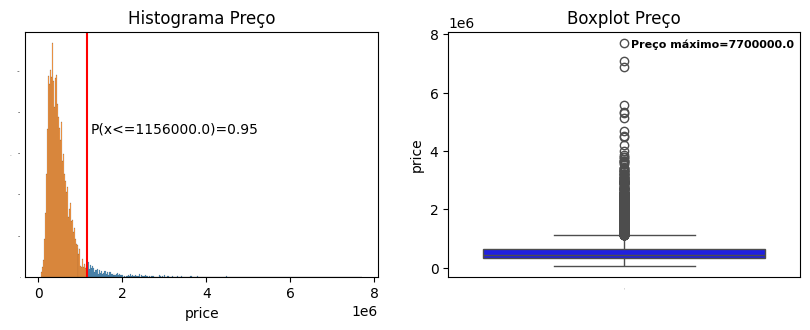

In [13]:
#fazendo uma copia com apenas a coluna que interessa
df_aux=df['price'].copy()
df_aux=pd.DataFrame(df_aux)

#fator de probabilidade
probi=0.95

#funções auxiliares
aux, acu, maxi=acumulativo(df_aux, probi)
df_aux.insert(1,'bool',prob(df_aux, aux))


fig=plt.figure(figsize=(10,7))


#histograma
ax=fig.add_subplot(2,2,1)
ax.set_title('Histograma Preço')
sns.histplot(data=df_aux[["price","bool"]],x="price",hue="bool",multiple="stack", legend=False)
plt.ylabel([], fontsize=0)
plt.ylabel([], fontsize=0)
plt.tick_params(axis='y', labelsize=0, length=0)
plt.axvline(x=maxi, ymin=0, ymax=700, color='red')
plt.text(maxi+100000, 700, f"""P(x<={maxi})={probi}""")



#boxplot
ax=fig.add_subplot(2,2,2)
ax.set_title('Boxplot Preço')
sns.boxplot(y="price",data=df,color='blue')
plt.xlabel([], fontsize=0)
plt.tick_params(axis='x', labelsize=0, length=0)

maximo=df['price'].max()
plt.text(0.02, maximo-150000, f"Preço máximo={maximo}", weight="bold",size=8)

plt.show()

Praticamente todos nossos dados de preços estão abaixo de 1 milhão, oque irá dificultar para o modelo a previsão para outliers, a não ser que haja características essenciais que caracterizam em sua maior parte preços de valores altos. Por exemplo, pode-se haver maior parte dos dados serem abaixo de 1 milhão, contudo ao saber localização (bairro, cidade, estado), ja ajudaria bastantes para detecção desses outliers. Pois bairros nobres tendem a terem casas mais caras, havendo uma variância menor nos preços das casas do bairro. Ou seja, uma características com menor variância para esses preços

In [14]:
colunas = list(df.columns)
column_remove = ['id','date','bedrooms','bathrooms','floors',
                 'waterfront','view', 'condition', 'grade',
                 'zipcode','lat', 'long','yr_built','yr_renovated','price']
for column in column_remove:
    colunas.remove(column)
len(colunas)


6

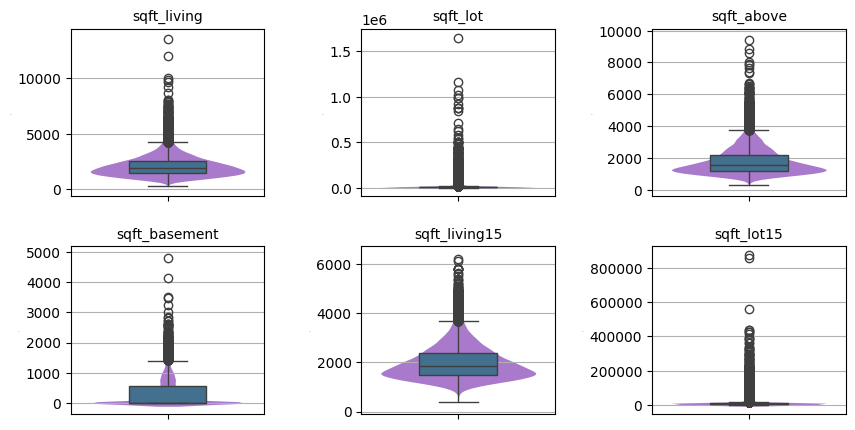

In [15]:
fig=plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.5, hspace=0.3)
cont = 1
for column in colunas:

    ax=fig.add_subplot(2,3,cont)
    ax_violin = sns.violinplot(df[column], color="#af52f4", inner=None, linewidth=0, saturation=0.5,ax=ax)
    sns.boxplot(df[column], saturation=0.5, width=0.4, boxprops={'zorder': 2}, ax=ax_violin)
    plt.title(column,fontsize=10)
    plt.ylabel([],fontsize=0)
    plt.grid(axis='y')
    cont+=1

In [16]:

for remover in ['id','date','price']:
    column_remove.remove(remover)

len(column_remove)

12

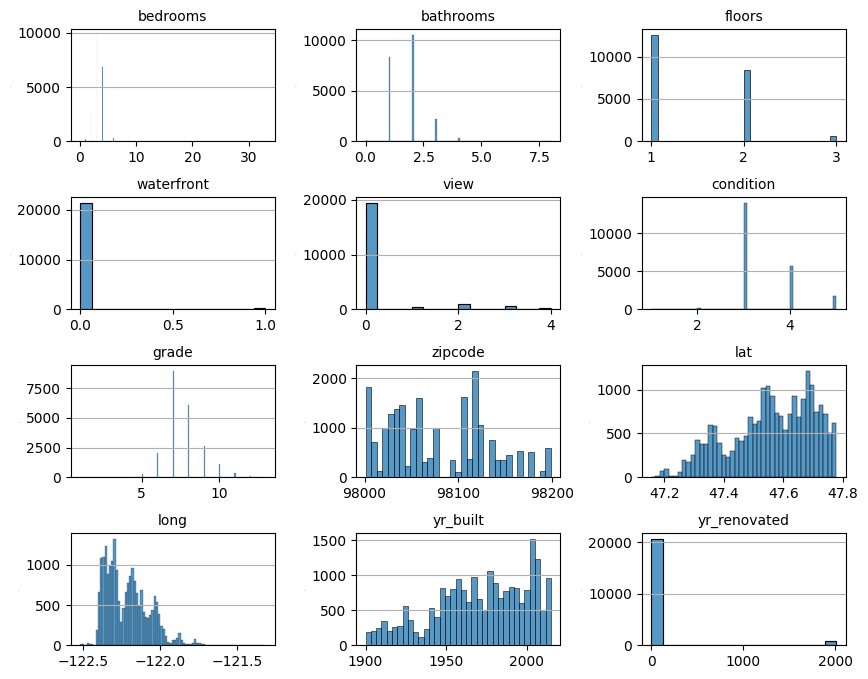

In [17]:
fig=plt.figure(figsize=(10,8))
plt.subplots_adjust(wspace=0.4, hspace=0.5)
cont = 1

for column in column_remove:

    ax=fig.add_subplot(4,3,cont)
    sns.histplot(df[column])
    plt.title(column,fontsize=10)
    plt.ylabel([],fontsize=0)
    plt.xlabel('')
    plt.grid(axis='y')
    cont+=1

In [18]:
df.describe().loc[['min','max']]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
min,1.000102e+06,2014-05-02 00:00:00,75000.0,0.0,0.0,290.0,520.0,1.0,0.0,0.0,...,1.0,290.0,0.0,1900.0,0.0,98001.0,47.1559,-122.519,399.0,651.0
max,9.900000e+09,2015-05-27 00:00:00,7700000.0,33.0,8.0,13540.0,1651359.0,3.0,1.0,4.0,...,13.0,9410.0,4820.0,2015.0,2015.0,98199.0,47.7776,-121.315,6210.0,871200.0


# Análise do Somatório do Preço Diariamente

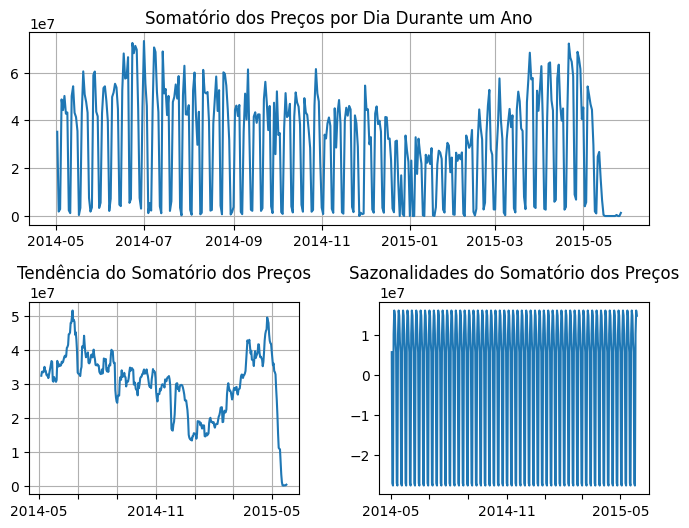

In [19]:
data_series_day=data_series.resample('D').sum()

decomposicao = seasonal_decompose(data_series_day)
tendencia = decomposicao.trend
sazonal = decomposicao.seasonal

fig=plt.figure(figsize=(8,6))
plt.subplots_adjust(wspace=0.3, hspace=0.4)

ax=fig.add_subplot(2,1,1)
ax.set_title('Somatório dos Preços por Dia Durante um Ano')
plt.plot(data_series_day)
plt.grid(axis='both')

ax=fig.add_subplot(2,2,3)

ax.set_title('Tendência do Somatório dos Preços')
plt.plot(tendencia)
for i,tick in enumerate(ax.xaxis.get_ticklabels()):
    if i == 0 or i == 3 or i == 6:
        tick.set_visible(True)
    else:
        tick.set_visible(False)
plt.grid(axis='both')


ax=fig.add_subplot(2,2,4)
ax.set_title('Sazonalidades do Somatório dos Preços')
plt.plot(sazonal)
for i,tick in enumerate(ax.xaxis.get_ticklabels()):
    if i == 0 or i == 3 or i == 6:
        tick.set_visible(True)
    else:
        tick.set_visible(False)

Uma coisa que pode influenciar os preços é a data, portanto realizamos somatório dos preços por dia e plotamos sua serie temporal. Contudo temos que ter em mente que essa serie é do somatório dos preços, e não dos preços em si, portanto a quantidade de casas para cada dia tem influência.

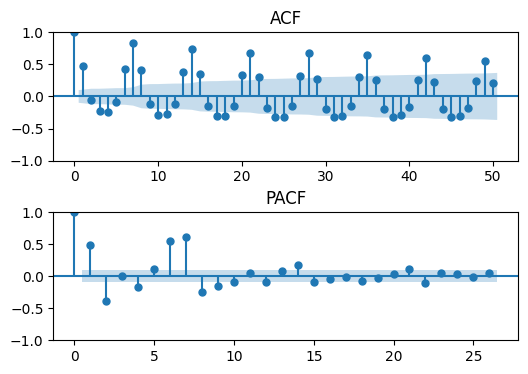

In [20]:
fig=plt.figure(figsize=(6,4))
plt.subplots_adjust(wspace=0, hspace=0.4)


ax=fig.add_subplot(2,1,1)
plot_acf(data_series_day,title='ACF',lags=50,alpha=.05,ax=ax)

ax=fig.add_subplot(2,1,2)
plot_pacf(data_series_day,title='PACF',ax=ax)

plt.show()

Podemos ver uma serie temporal do somatório diário no qual se tem um efeito sazonal de periodo de 7 dias pelo que indica o ACF

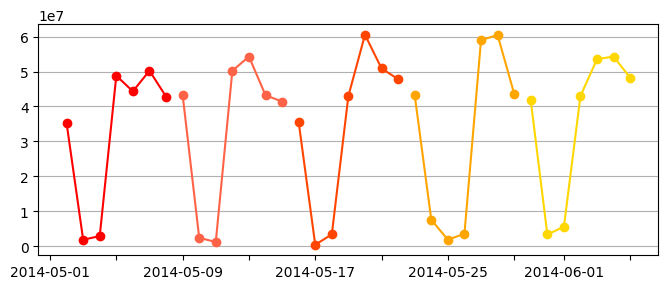

In [21]:
fig=plt.figure(figsize=(8,3))

ax=fig.add_subplot(1,1,1)
colors = ['red','tomato','orangered','orange','gold']


for i in range(5):
    plt.plot(data_series_day.iloc[i*7:(i+1)*7],marker='o',color=colors[i],label=f'semana {i}')


for i,tick in enumerate(ax.xaxis.get_ticklabels()):
    if i%2 == 0:
        tick.set_visible(True)
    else:
        tick.set_visible(False)

#plt.legend()

plt.grid(axis='y')

Podemos observar melhor essa sazonalidade diária pelo gráfico anterior, no qual se começa com um faturamento diário alto, logo em seguida uma queda, para novamente haver uma alta nos últimos 4 dias

c:\Users\Marcio\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:754: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  posy = float(self.convert_yunits(self._y))
c:\Users\Marcio\AppData\Local\Programs\Python\Python310\lib\site-packages\matplotlib\text.py:895: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(self._y))


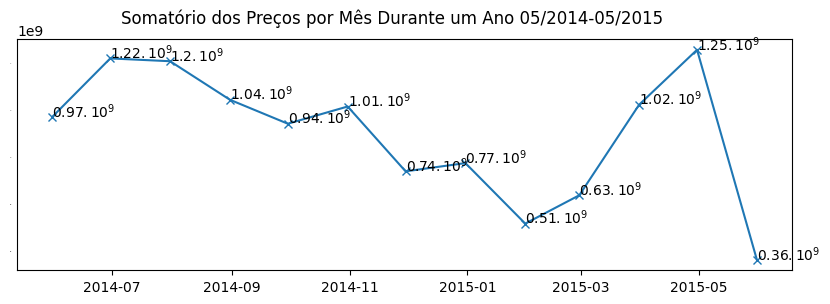

In [22]:
fig=plt.figure(figsize=(10,3))


#------------------------------------------------------------------
ax=fig.add_subplot(1,1,1)
fig.suptitle('Somatório dos Preços por Mês Durante um Ano 05/2014-05/2015')

data_series_mes=data_series.resample('M').sum()
plt.plot(data_series_mes, 'x-')

plt.tick_params(axis='y', labelsize=0, length=0)
aux=[datetime.datetime.strptime(i.isoformat()[:10],'%Y-%m-%d') for i in data_series_mes.index]
for i in aux:
    plt.text(i, data_series_mes.loc[i], f"{round(data_series_mes.loc[i].values[0]/1000000000,2)}"+r'$.10^{9}$')

Observe que o faturamento sofre tendencias ao passar os meses, oque afeta o ciclo sazonal, pois se tem uma tendencia de crescimento, cada periodo do ciclo terá um valor maior ou menor do que seu respectivo periodo no ciclo anterior do mês anterior.

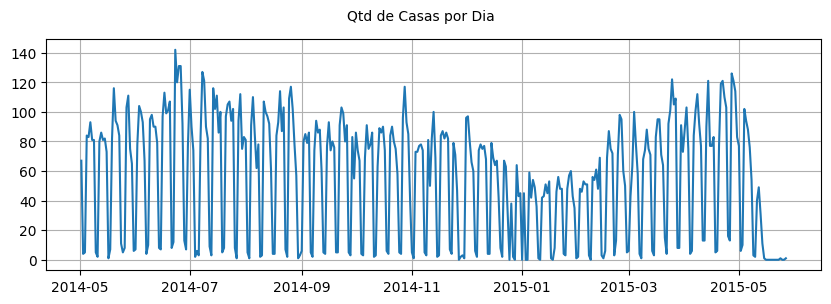

In [23]:
fig=plt.figure(figsize=(10,3))
fig.suptitle('Qtd de Casas por Dia', fontsize=10)

plt.plot(data_series.resample('D').count())
plt.grid(axis='both')

Entretanto quando observamos a quantidade de casa vendidas por dia, nota-se uma grande semelhança com o gráfico do somatório de preços, indicando uma relação linear entre as duas variáveis. Ou seja, oque irá afetar principalmente o faturamento diário, será a quantidade vendida, e não o preço das casas. 

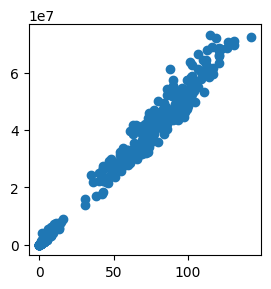

In [24]:
fig=plt.figure(figsize=(3,3))
plt.scatter(data_series.resample('D').count()['price'].values,data_series_day['price'].values)


Pelo gráfico acima podemos confirmar a relação linear entre quantidade e faturamento. Isso nos dar indicios de que a distribuição dos preços não tendem a mudar dependendo do faturamento. Por exemplo, o faturamento porque o preço das casas vendidas caiu, ou seja, uma queda de preços afetando o faturamento. Contudo, oque ralmente esta mais afetando é a quantidade de casa vendidas.

Mesmo sabendo que o fator principal do baixo faturamento é a quantidade, e não os preços. Entretanto iremos fazer um estudo de como se comportam os preços altos ao longo do tempo

Colocando indicador do dia da semana na data

In [25]:
aux = []
index_day = 0
while index_day < len(data_series_day):
    for i in range(7):
        if(index_day+i<len(data_series_day)):
            aux.append(i)
        else:
            break
    index_day = index_day+7

data_series_day['dia'] = aux


aux = []
for i in range(len(df)):
    aux.append(data_series_day.loc[df.iloc[i]['date']]['dia'])

df['dia'] = aux
    

Indicador de mes para analises

In [26]:
indice_mes = 0
indice = 0
aux=[]
while(indice < len(df)):
    mes_atual = df['date'].iloc[indice].month
    mes_inicio = mes_atual
    while(mes_atual == mes_inicio and indice < len(df)):

        aux.append(indice_mes)
        if(indice < len(df)-1):
            indice += 1
            mes_atual = df['date'].iloc[indice].month
        else:
            indice += 1
    indice_mes += 1

In [27]:
df['month'] = aux

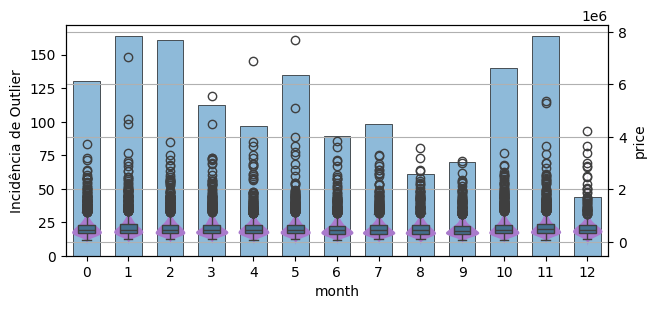

In [28]:
fig, ax1 = plt.subplots(figsize=(7, 3))

ax1_bars = range(13)
sns.histplot(data=df.query(f"price>1000000"),x='month', shrink=.8,ax=ax1,alpha=0.5,bins=[x for i in ax1_bars for x in (i-0.4,i+0.4)])
plt.ylabel('Incidência de Outlier')

ax2 = ax1.twinx()
ax = sns.violinplot(data=df, x='month', y='price', color="#af52f4", inner=None, linewidth=0, saturation=0.5,ax=ax2)
sns.boxplot(data=df, x='month', y='price', saturation=0.5, width=0.4, boxprops={'zorder': 2}, ax=ax)

plt.grid(axis='y')

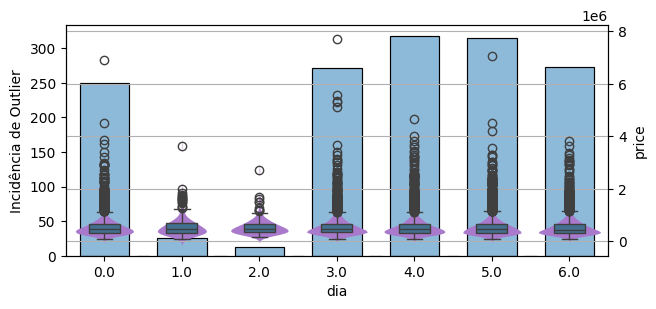

In [29]:
fig, ax1 = plt.subplots(figsize=(7, 3))

ax1_bars = [0,1,2,3,4,5,6]
sns.histplot(data=df.query(f"price>1000000"),x='dia', shrink=.8,ax=ax1,alpha=0.5,bins=[x for i in ax1_bars for x in (i-0.4,i+0.4)])
plt.ylabel('Incidência de Outlier')

ax2 = ax1.twinx()
ax = sns.violinplot(data=df, x='dia', y='price', color="#af52f4", inner=None, linewidth=0, saturation=0.5,ax=ax2)
sns.boxplot(data=df, x='dia', y='price', saturation=0.5, width=0.4, boxprops={'zorder': 2}, ax=ax)

plt.grid(axis='y')

Perceba que os dias da semana interferem na amplitude e na quantidade de preços alto, infelizmente em geral a distribuição ainda são praticamente a mesma entre os dias, ou seja, não ajudaria em identificar os preços altos pois continuam sendo outliers nessas caracteristicas.

In [30]:
data_series_outlier = data_series.query("price>=1000000").resample('D').count()

<Axes: xlabel='date', ylabel='price'>

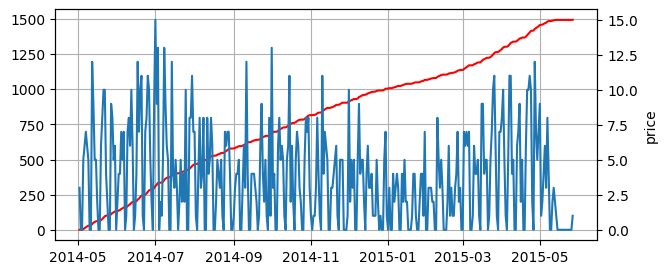

In [31]:
fig, ax1 = plt.subplots(figsize=(7, 3))
plt.plot(data_series_outlier.index, np.cumsum(np.array(data_series_outlier),axis=0),color='red')
plt.grid(axis='both')

ax2 = ax1.twinx()
sns.lineplot(data=data_series_outlier,x='date',y='price',ax=ax2)

<Axes: xlabel='long', ylabel='lat'>

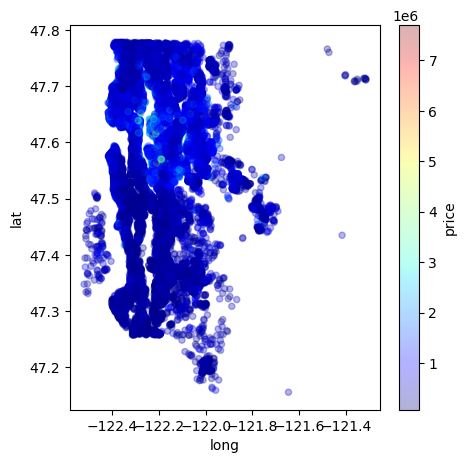

In [32]:
df.plot(kind="scatter", x="long", y="lat", alpha=0.3, figsize=(5,5),
c="price", cmap=plt.get_cmap("jet"), colorbar=True,
)

Infelizmente as caracteristicas geográficas não nos fornecem informação relevante, pois os dados de maiores preços não estão localizados em áreas especificas

In [33]:
x = df.drop(['price','date','id'],axis=1).values
y = df['price'].values
mi = fs.mutual_info_classif(x,y)

In [34]:
mi = pd.Series(mi)
mi.index =df.drop(['price','date','id'],axis=1).columns
mi.sort_values(ascending=False,inplace=True)

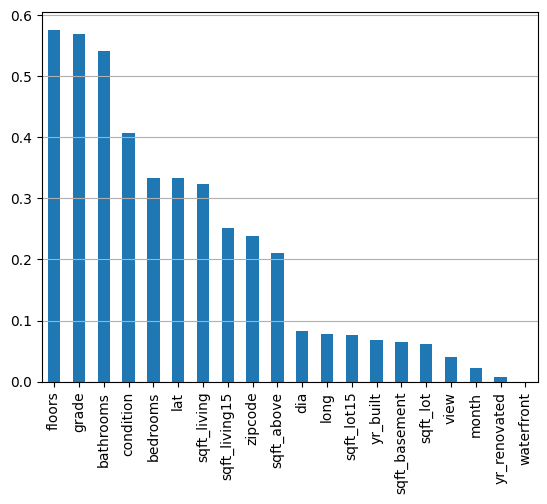

In [35]:
mi.plot.bar()
plt.grid(axis='y')

In [36]:
columns_select = mi.index[:10]

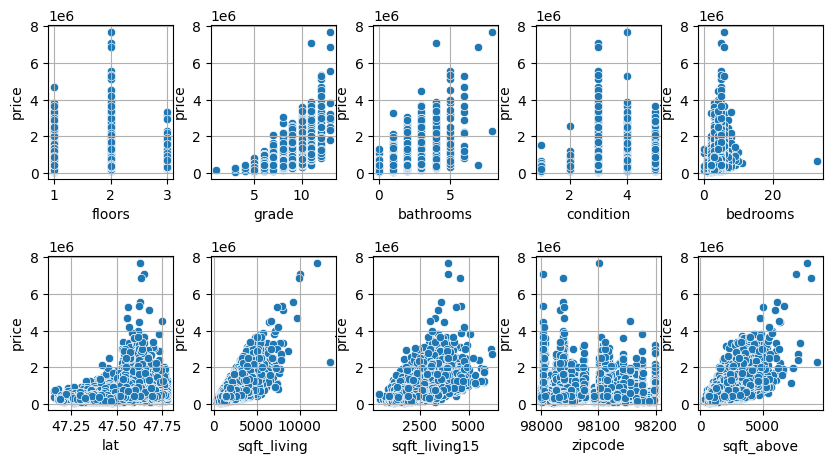

In [37]:
fig=plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.3, hspace=0.5)
for column in range(len(columns_select)):

    ax=fig.add_subplot(2,5,column+1)
    sns.scatterplot(data=df,x=columns_select[column],y='price')
    plt.grid(axis='both')

In [45]:
columns = list(columns_select)
#columns.extend(('tendencia','dia','QtdOutLiers-1','QtdOutLiers-2','QtdOutLiers-3','QtdOutLiers-4','QtdOutLiers-5','QtdOutLiers-6','QtdOutLiers-7'))

In [49]:
X = df[columns]
X.to_csv("C:/Users/Marcio/Documents/Codigos/Previsao_Precos/arquivos/X.csv")

In [50]:
Y = df['price']
Y.to_csv("C:/Users/Marcio/Documents/Codigos/Previsao_Precos/arquivos/Y.csv")